___

# Machine Learning in Geosciences ] 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz


## Deep Learning - Convolutional Neural Networks - Segmentation

Task: This notebook presents a CNN segmentation model programmed using the PyTorch library https://pytorch.org on the example of simulated images containing 3 shapes in random position. 

Architecture: U-Net

**Tasks**: 
    
 1. Develop a complete workflow with the CNN architecture for object segmentation.
    
 2. Change the noise level from 0.1 to 0.5 and 0.9 and evaluate the learning accuracy.

### Architektura U-Net

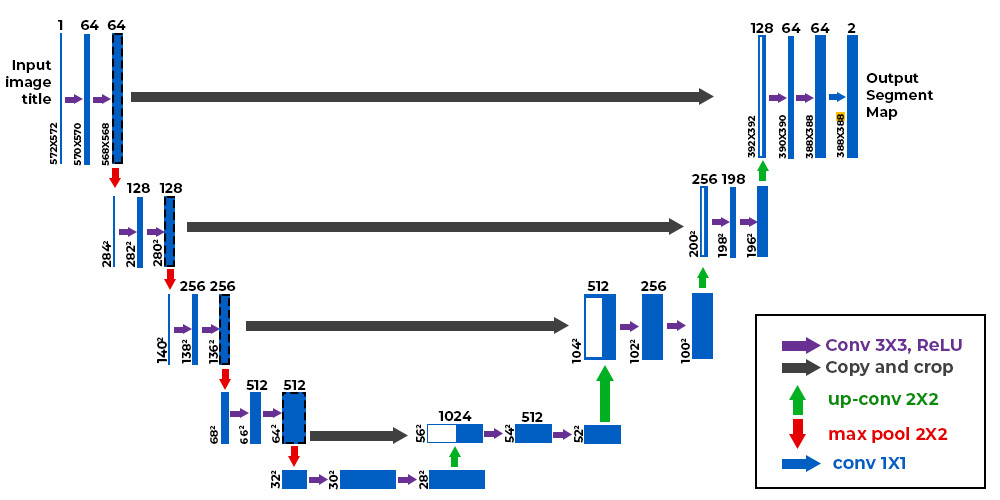

#### Main steps of the modelling workflow 
1. Loading the dataset
2. Create iterable dataset
3. Create model class
4. Instantiate model class
5. Instantiate loss class
6. Instantiate optimizer class
7. Model training 

In [5]:
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import time 

# PyTorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.autograd import Variable

from torchsummary import summary
import segmentation_models_pytorch as smp

c:\Python\Python312\envs\IF_HydroSim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulated data 

In [27]:
# Skript pro simulaci dat 
from simulate_images import generate_image_shapes

In [28]:
# Generating dat
height, width, count = 32, 32, 9
noise = 0.2
X, Y, y_label = generate_image_shapes(height, width, count, noise)

In [29]:
X.shape

(9, 1, 32, 32)

In [30]:
torch.squeeze(torch.tensor(X)).shape

torch.Size([9, 32, 32])

In [31]:
Y.shape

(9, 1, 32, 32)

In [32]:
np.unique(y_label)

array([0, 1, 2])

Label: 1


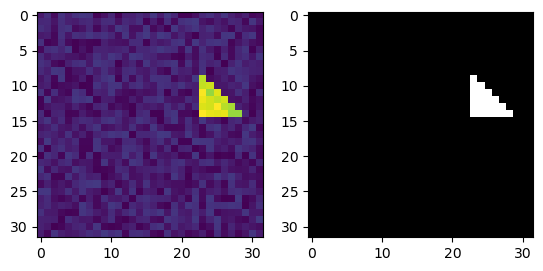

In [33]:
image_no=1
print(f'Label: {y_label[image_no]}')
plt.subplot(1, 2, 1)
plt.imshow(X[image_no][0,:,:])
plt.subplot(1, 2, 2)
plt.imshow(Y[image_no][0,:,:], cmap='gray') 

Label: 2


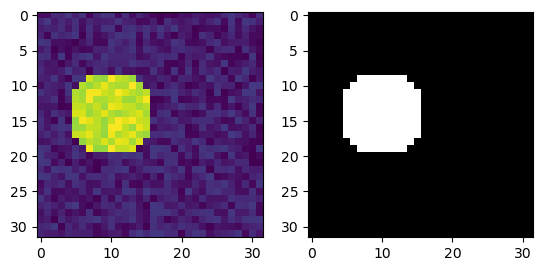

In [34]:
image_no=2
print(f'Label: {y_label[image_no]}')
plt.subplot(1, 2, 1)
plt.imshow(X[image_no][0,:,:])
plt.subplot(1, 2, 2)
plt.imshow(Y[image_no][0,:,:], cmap='gray') 

Label: 0


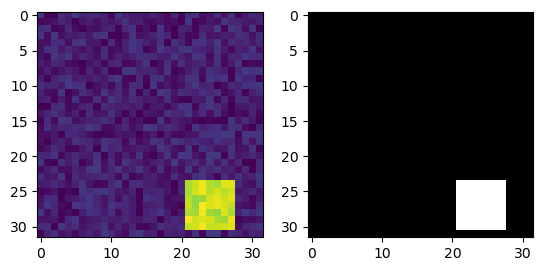

In [35]:
image_no=7
print(f'Label: {y_label[image_no]}')
plt.subplot(1, 2, 1)
plt.imshow(X[image_no][0,:,:])
plt.subplot(1, 2, 2)
plt.imshow(Y[image_no][0,:,:], cmap='gray') 

### 1. Class for loading the dataset

In [15]:
class SimDataset(Dataset):
    def __init__(self, height, width, count, noise, transform=None):
        self.input_images, self.target_masks, self.target_labels= generate_image_shapes(height, width, 
                                                                                        count, noise)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        # image typu float
        image_torch = torch.from_numpy(image).float()
        image_torch_rgb = torch.squeeze(torch.stack((image_torch,image_torch,image_torch),dim=0))
        # segmentační maska
        mask = self.target_masks[idx]
        # segmentacni maska typu long (int64)
        mask_torch = torch.squeeze(torch.from_numpy(mask).long())
        # kód tvaru 
        label= self.target_labels[idx] 
    
        if self.transform:
            image = self.transform(image)

        return [image_torch_rgb, mask_torch, label]


In [16]:
# test 
height, width, count = 32, 32, 9 
noise = 0.1
train_size = 1 
sd = SimDataset(height, width, train_size, noise) 

In [17]:
dl =  DataLoader(sd, batch_size=1, shuffle=True, num_workers=0)
sample, msk, lbl = next(iter(dl))
sample[0].shape

torch.Size([3, 32, 32])

In [18]:
msk.shape

torch.Size([1, 32, 32])

### 2. Create iterable dataset

In [19]:
def get_data_loaders(height, width, noise, train_size, test_size, batch_size=5):

    # height, width, count = 64, 64
    train_set = SimDataset(height, width, train_size, noise) # , transform = trans
    test_set = SimDataset(height, width, test_size, noise) # , transform = trans


    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)


    return train_dataloader, test_dataloader


In [20]:
### Příprava dat do dataloaderu (iterátor) 
batch_size = 9
height, width = 32, 32
noise = 0.1
train_dataloader, test_dataloader = get_data_loaders(height, width, noise, train_size=500, test_size=500, 
                                                     batch_size=batch_size)

In [21]:
sample = next(iter(train_dataloader))
image, mask, label = sample

In [22]:
image.dtype


torch.float32

In [23]:
mask.dtype


torch.int64

###  3. Create model class

### Segmentation models
https://smp.readthedocs.io/en/latest/index.html 

**Segmentation model is based on PyTorch nn.Module:** 



`
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name=„resnet34“,     # emcoder, mobilenet_v2 or efficientnet-b7, ...
    encoder_weights=„imagenet“,  # weights initialization 
    in_channels=1,               # input channels (1 for grayscale images, 3 for RGB)
    classes=3,                   # output (number of classes)
)
`

**Model learning** 

`
for images, gt_masks in dataloader:

    predicted_mask = model(image)
    loss = loss_fn(predicted_mask, gt_masks)

    loss.backward()
    optimizer.step()
`

### 4. Instantiate model class

In [49]:
model = smp.Unet(
    encoder_name="mobilenet_v2",     # Encoder, mobilenet_v2 or efficientnet-b7, ...
    encoder_weights="imagenet",      # Weights initialization
    in_channels=3,                   # Input channels (3 for RGB images)
    classes=3,                       # Output (number of classes)
    activation=None,
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32]
)


In [53]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

In [54]:
# Prarametry modelu 
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(params)

[864, 32, 32, 288, 32, 32, 512, 16, 16, 1536, 96, 96, 864, 96, 96, 2304, 24, 24, 3456, 144, 144, 1296, 144, 144, 3456, 24, 24, 3456, 144, 144, 1296, 144, 144, 4608, 32, 32, 6144, 192, 192, 1728, 192, 192, 6144, 32, 32, 6144, 192, 192, 1728, 192, 192, 6144, 32, 32, 6144, 192, 192, 1728, 192, 192, 12288, 64, 64, 24576, 384, 384, 3456, 384, 384, 24576, 64, 64, 24576, 384, 384, 3456, 384, 384, 24576, 64, 64, 24576, 384, 384, 3456, 384, 384, 24576, 64, 64, 24576, 384, 384, 3456, 384, 384, 36864, 96, 96, 55296, 576, 576, 5184, 576, 576, 55296, 96, 96, 55296, 576, 576, 5184, 576, 576, 55296, 96, 96, 55296, 576, 576, 5184, 576, 576, 92160, 160, 160, 153600, 960, 960, 8640, 960, 960, 153600, 160, 160, 153600, 960, 960, 8640, 960, 960, 153600, 160, 160, 153600, 960, 960, 8640, 960, 960, 307200, 320, 320, 409600, 1280, 1280, 294912, 256, 256, 589824, 256, 256, 322560, 128, 128, 147456, 128, 128, 82944, 64, 64, 36864, 64, 64, 18432, 32, 32, 9216, 32, 32, 864, 3]


###  5. Instantiate loss class

In [55]:
entropy = nn.CrossEntropyLoss()

### 6. Instantiate optimizer class

In [56]:
# optimizer 
learning_rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 7. Model training

In [ ]:
import time
import torch
from torch.autograd import Variable

# Training
start = time.time()

# Epochs (TODO: more after test run)
num_epochs = 5
train_loss, test_loss = [], []

for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)  # Training mode
            dataloader = train_dataloader
        else:
            model.train(False)  # Evaluation mode
            dataloader = test_dataloader

        step = 0
        # Iteration over data in batches
        for x, masks, y in dataloader:
            step += 1
            x = Variable(x)
            y = Variable(masks)

            # Forward
            if phase == 'train':
                # Remove gradients
                optimizer.zero_grad()
                outputs = model(x)
                loss = entropy(outputs, y)

                # Backpropagation
                loss.backward()
                # Optimize
                optimizer.step()

            else:
                # Test
                with torch.no_grad():
                    outputs = model(x)
                    loss = entropy(outputs, y.long())

            # Evaluation
            if phase == 'train':
                train_loss.append(loss.item())  # Use loss.item() to get the scalar value
                if step % 10 == 0:
                    print('Epoch: {} Train loss: {}'.format(epoch, loss.item()))
            else:
                test_loss.append(loss.item())  # Use loss.item() to get the scalar value
                if step % 10 == 0:
                    print('Epoch: {} Test loss: {}'.format(epoch, loss.item()))

print('---')
time_elapsed = time.time() - start
print('Training finished in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Epoch: 0 Train loss: 0.0003921117167919874
Epoch: 0 Train loss: 0.0005593348760157824
Epoch: 0 Train loss: 0.00016710508498363197
Epoch: 0 Train loss: 0.0004576309002004564
Epoch: 0 Train loss: 0.00015890740905888379
Epoch: 0 Test loss: 0.0002198005822720006
Epoch: 0 Test loss: 0.00030819152016192675
Epoch: 0 Test loss: 0.00015152838022913784
Epoch: 0 Test loss: 0.000403550366172567
Epoch: 0 Test loss: 0.00035633589141070843
Epoch: 1 Train loss: 0.0001238466502400115
Epoch: 1 Train loss: 0.00020503715495578945
Epoch: 1 Train loss: 0.000632737297564745
Epoch: 1 Train loss: 0.00020415708422660828
Epoch: 1 Train loss: 0.00011811410513473675
Epoch: 1 Test loss: 0.00016114242316689342
Epoch: 1 Test loss: 0.0003420287393964827
Epoch: 1 Test loss: 0.0001748009235598147
Epoch: 1 Test loss: 8.492299093632028e-05
Epoch: 1 Test loss: 5.941079871263355e-05
Epoch: 2 Train loss: 7.008433749433607e-05
Epoch: 2 Train loss: 0.000329153670463711


#### Plot training and testing evolution 

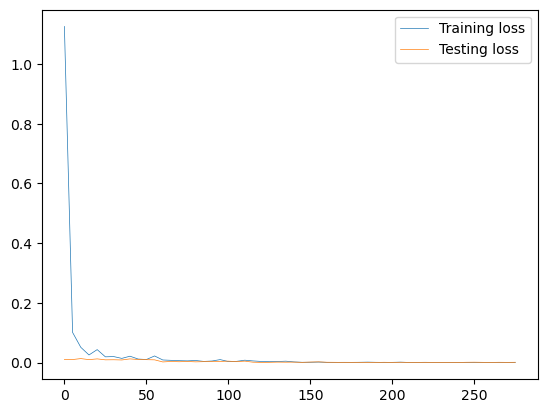

In [63]:
plt.plot(range(0, len(train_loss), 5), [l for l in train_loss[::5]], 
         linewidth=0.5, label='Training loss')
plt.plot(range(0, len(test_loss), 5), [l for l in test_loss[::5]], 
         linewidth=0.5, label='Testing loss')
plt.legend()